# Second order stochastic methods for CryoEM -- OASIS

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [ ]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

In [ ]:
out_dir = out_dir = '../data/out_dev/'

In [ ]:
nx0 = imgs0.shape[1]
nx_crop = 128 # 64
N = 80000 # 20000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[135].reshape([nx_crop,nx_crop]))));plt.colorbar()

In [ ]:
#del(imgs0)

### Only volume reconstruction for now - SGD vs OASIS

In [ ]:
#sigma_noise_est = sigma_noise
#sigma_noise = jnp.ones(sigma_noise.shape)
sigma_noise = sigma_noise_est

In [ ]:
sigma_noise

In [ ]:
jnp.max(sigma_noise_est)/jnp.min(sigma_noise_est)

In [ ]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
alpha =  1e-8 #1e-9 # 1e-5

slice_obj = Slice(x_grid, mask = mask)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

Use the same datasets, loss, grad, hvp, x0, D0 for SGD and OASIS

In [ ]:
idxrand = np.random.permutation(N)
idx1 = idxrand[:N//2]
idx2 = idxrand[N//2:]

In [ ]:
grad_func1, loss_func1, hvp_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2, hvp_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)


In [ ]:
200000

In [ ]:
iters = 2000
batch_sz = 100
key, *subkeys = random.split(key, 2*iters+1)

zD01z = np.zeros([nx,nx,nx])
zD02z = np.zeros([nx,nx,nx])

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], [nx,nx,nx], dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N//2)[:batch_sz]
    
    zD01z += z * hvp_func1(x0, z, idx)
    zD02z += z * hvp_func2(x0, z, idx)
    
D01 = jnp.array(zD01z/iters)
D02 = jnp.array(zD02z/iters)

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D01[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01))/jnp.min(jnp.abs(D01)))

In [ ]:
DD = jnp.maximum(jnp.abs(D01), 1e-9)
plt.imshow(jnp.fft.fftshift(jnp.abs(DD[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(DD)))
print(jnp.max(jnp.abs(DD)))

In [ ]:
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D02)))
print(jnp.max(jnp.abs(D01-D02)))

#### SGD

In [ ]:
N_epochs = 5
batch_size = 1000
step_size =  1e6 #1e-4 #1e-1 #1e-5 #1e-2 #1000000 # 1e-3

# Step sizes (empirically found, i.e. the largest that doesn't lead to loss exploding): 

# 10k imgs, 64px:
#   no sigma_noise, no precon: 1e1 V
#   no sigma_noise, with precon: 1e-2 V
#   with sigma_noise, no precon: 1e6 V
#   with sigma_noise, with precon: 1e-1 V

# 40k imgs, 128px , reg 1e-5
#  no sigma_noise, no precon: 1e1 V
#  no sigma_noise, with precon: 1e-1 V

# ---

#  with sigma_noise, no precon: 1e5, 
#  with_sigma_noise, with precon: 1e-3, 

In [ ]:
P1 = None
#P1 = 1/D01

key, subkey = random.split(key)
x01 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N//2, x01, step_size, N_epochs, batch_size, P = P1, verbose=True, iter_display=1)


In [ ]:
P2 = None
#P2 = 1/D02

key, subkey = random.split(key)
x02 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N//2, x02, step_size, N_epochs, batch_size, P = P2, verbose=True, iter_display=1)


In [ ]:
plt.plot(loss_rec1)
plt.plot(loss_rec2)

In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.imag(v_rec1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.imag(v_rec2))); plt.colorbar()

In [ ]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

In [ ]:
res, fsc_sgd, shell_points = calc_fsc(v_rec1, v_rec2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_sgd)
plt.gca().invert_xaxis()
plt.title("FSC")

In [ ]:
print(fsc_sgd[15])
print(fsc_sgd[16])
print(res_angs[15])
print(res_angs[16])

#### OASIS

In [ ]:
N_epoch = 5 #30
beta2 = 0.99
eta0 = 1e #1e-5 #0.0001 #0.1/0.001/0.01/0.15
batch_size = 1000
alpha = 0 #1e-16 #0.1 # 0.01

D0bad = jnp.array(np.random.randn(*D01.shape))

key, subkey = random.split(key)


# Step sizes (eta0): 
#
# 10k imgs, 64px:
#   no sigma_noise: 1e-4 (1e-3 if beta2=1) V
#   with sigma_noise: 1e-4 V
#
# 40k imgs, 128px: reg 1e-5
#   no sigma_noise: 1e-4 V
#   with sigma_noise: 1e-2

In [ ]:
key, subkey1, subkey2 = random.split(key, 3)
x01 = random.normal(subkey1, [nx,nx,nx], dtype=jnp.complex128)
print(subkey2)

v_rec_o1, loss_o1 = oasis(subkey2, loss_func1, grad_func1, hvp_func1, x01, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


In [ ]:
key, subkey1, subkey2 = random.split(key, 3)
x0 = random.normal(subkey1, [nx,nx,nx], dtype=jnp.complex128)

#v_rec_oa1, loss_oa1 = oasis_adaptive(subkey2, loss_func1, grad_func1, hvp_func1, x0, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


In [ ]:
key, subkey1, subkey2 = random.split(key, 3)

x02 = random.normal(subkey1, [nx,nx,nx], dtype=jnp.complex128)
print(subkey2)

v_rec_o2, loss_o2 = oasis(subkey2, loss_func2, grad_func2, hvp_func2, x02, eta0, D02, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


In [ ]:
plt.plot(loss_o1)
plt.plot(loss_o2)
plt.plot(loss_rec1)
plt.plot(loss_rec2)


In [ ]:
plt.rcParams["figure.figsize"]= 12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.real(v_rec_o1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_o2))); plt.colorbar()

plt.rcParams["figure.figsize"]= 6, 6


In [ ]:
mip_z(np.imag(x01-x02)); plt.colorbar()

In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.imag(v_rec_o1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.imag(v_rec_o2))); plt.colorbar()

In [ ]:
v_rec_ol1, _ = rescale_larger_grid(v_rec_o1, x_grid, nx0)
vr_o1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol1)))

v_rec_ol2, _ = rescale_larger_grid(v_rec_o2, x_grid, nx0)
vr_o2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol2)))

plt.subplot(1,2,1)
mip_z(vr_o1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_o2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_o1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_o2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o2.astype(np.float32))   

In [ ]:
res, fsc_o, shell_points = calc_fsc(v_rec_o1, v_rec_o2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")

In [ ]:
plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS"])

In [ ]:
print(fsc_o[24])
print(fsc_o[25])
print(res_angs[24])
print(res_angs[25])

In [ ]:
fsc_o

In [ ]:
res_angs

In [ ]:
#Nn = N//2

In [ ]:
#loss_func1(v_rec1, jnp.arange(Nn))

In [ ]:
#loss_func2(v_rec2, jnp.arange(Nn))

In [ ]:
#loss_func1(v_rec_o1, jnp.arange(Nn))

In [ ]:
#loss_func2(v_rec_o2, jnp.arange(Nn))

#### Now the same with CG

In [ ]:
N_iter = 300


In [ ]:
AA1, Ab1 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], v_rec1.shape, sigma_noise)
AA2, Ab2 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], v_rec1.shape, sigma_noise)


In [ ]:
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

v_rec_cg1, _ = cg(AA1, Ab1, x0, N_iter, verbose=True)

In [ ]:
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

v_rec_cg2, _ = cg(AA2, Ab2, x0, N_iter, verbose=True)

In [ ]:
Nn=N//2

In [ ]:
loss_func1(v_rec_cg1, jnp.arange(Nn))

In [ ]:
loss_func2(v_rec_cg2, jnp.arange(Nn))

In [ ]:
loss_func2(v_rec2, jnp.arange(Nn))

In [ ]:
loss_func2(v_rec_o2, jnp.arange(Nn))

In [ ]:
loss_func2(v_rec_cg2, jnp.arange(Nn))

In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_cg1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_cg2))); plt.colorbar()

In [ ]:
v_rec_cgl1, _ = rescale_larger_grid(v_rec_cg1, x_grid, nx0)
vr_cg1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl1)))

v_rec_cgl2, _ = rescale_larger_grid(v_rec_cg2, x_grid, nx0)
vr_cg2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl2)))

plt.subplot(1,2,1)
mip_z(vr_cg1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_cg2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_cg1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_cg2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg2.astype(np.float32))  

In [ ]:
res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec_cg2, [1, nx_crop])
#res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec2, [1, nx_crop])

res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")

In [ ]:
fsc_cg

In [ ]:
plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS", "CG"])

In [ ]:
print(fsc_cg[11])
print(fsc_cg[12])
print(res_angs[11])
print(res_angs[12])

### Notes:

* It's important to use a large batch size for both SGD and OASIS: 1000 for 64-128px is good.
* OASIS rec with fixed rate is the same as SGD with D0 preconditioner,  the loss and results/FSC are almost identical (since here the Hessian doesn't depend on the current iterate and therefore is estimated perfectly at the beginning). -- actually not true in my latest experiments and I don't know why
* When using no $\sigma_{noise}$ with $128$ pixels and 40,000 images, both OASIS and SGD with precon required higher regularization parameter $10^{-5}$ compared to the other runs, where I used reg param $10^{-9}$
* I should with a dataset with no heterogeneity in the future
* Still don't know why the adaptive version fails

In [ ]:
pixel_size * 320/128

### Results:

Showing resolution cutoff at $FSC=0.5$ everywhere:

#### 1. Small data: `nx_crop=64px` and 10,000 images in each half set, 30 epochs (for SGD/OASIS) and 300 iters (for CG):

Everything here is with regularization parameter $10^{-9}$

no $\sigma_{noise}$:
* SGD no precon: $\approx 20 Å$ 
* SGD with precon:  $\approx 20 Å$ 
* OASIS: $FSC \geq 0.6$
* CG: $\approx 20 Å$

with $\sigma_{noise}$:

* SGD no precon:  $\approx 20 Å$ 
* SGD with precon: $\approx 20 Å$ 
* OASIS: above $FSC \geq 0.6$ all the way 
* CG: converges to random stuff for some reason 

#### 2. Large data: `nx_crop=128px` and 40,000 images in each half set, 10 epochs:

no $\sigma_{noise}$, regularization param $10^{-5}$
* SGD no precon:  $\approx 15 Å$  V
* SGD with precon: $\approx 18 Å$  V
* OASIS: $\approx 9.6 Å$ 

--- Below needs to be rerun

with $\sigma_{noise}$: 
* SGD no precon: $\approx 13 Å$ with reg $10^{-9}$, 30 epochs
* SGD with precon: 
* OASIS: $\approx 9.3 Å$ with reg $10^{-9}$ 30 epochs. 

### TODO:

* Fix the handling of the imaginary part -- I don't know if the loss for OASIS explodes in imaginary part only because of this issue or because of the low regularization param.

# Figuring out the algorithm, running it on toy problem

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [3]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

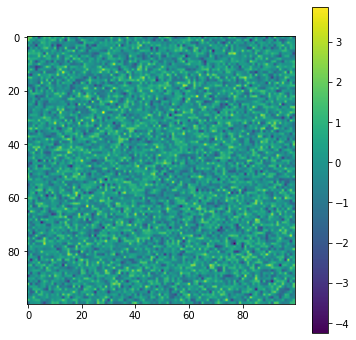

In [5]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n), dtype=jnp.complex128)
A = A.T + A

plt.imshow(jnp.real(A)); plt.colorbar()

In [6]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [7]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [8]:
d = np.zeros((iters, n), dtype=A.dtype)
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [9]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

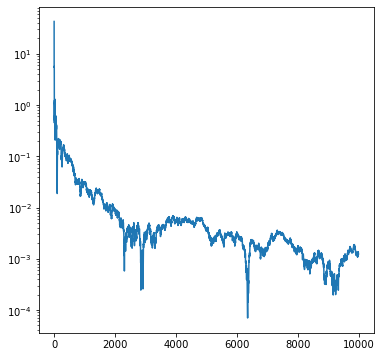

In [10]:
plt.semilogy(jnp.abs(err))

#### Hessian-vector product in JaX

In [11]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [12]:
b = A @ x0 
f = lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A@x-b)))

In [13]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [15]:
%timeit hvp0(f, x, v)

%timeit hvp(f, (x,), (v,))

v1 = hvp0(f, x, v)
v2 = hvp(f, (x,), (v,))
jnp.sum(jnp.abs(v1-v2))

9.55 ms ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.08 ms ± 9.79 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


DeviceArray(0., dtype=float64)

#### Toy problem

Condition number =  3.33e+05


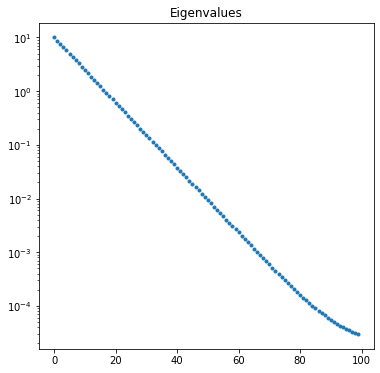

In [16]:
key, *subkey = random.split(key, 3)

x_gt = random.normal(subkey[0], (n,), dtype=jnp.complex128)

A = random.normal(subkey[1], (n,n), dtype=x_gt.dtype)
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
assert(jnp.max(jnp.imag(evals)) < 1e-13)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)

evals = jnp.real(evals)
plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [23]:
sig_noise = 1
lam = 0.1

key, subkey = random.split(key)

b = A @ x_gt  + random.normal(subkey, (n,)) * sig_noise

F = jax.jit(lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A @ x - b)) + lam * jnp.mean(jnp.conj(x)*x)))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
#hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
#print(f"hessianF(x_gt) = {hessianF(x_gt)}")


f(x_gt + 1) = 5.764996802179739
f(x_gt) = 1.2041735852363287
gradF(x_gt) = [ 0.01082507+2.14507118e-03j -0.03934399+5.79792663e-04j
  0.08205329+9.14508960e-04j -0.04865967+6.93515670e-04j
  0.03849571-5.25075929e-04j -0.01485263+7.82995038e-04j
  0.07924394+2.11334575e-03j -0.02962658+2.42216704e-03j
  0.009461  -8.99981188e-04j  0.00301585-7.12240898e-04j
  0.07542139-1.54814010e-03j  0.04248954+2.81560997e-03j
 -0.03905625-2.57546493e-04j  0.06212396-2.44592431e-04j
 -0.05625597+4.59023341e-04j -0.01367224+9.52341894e-04j
 -0.0552688 +2.81900576e-05j  0.03551437+1.52767481e-03j
 -0.05062795-1.52580977e-03j  0.02017774+2.00515485e-03j
  0.03479018-1.02174468e-03j  0.03314085+6.30947856e-04j
  0.02420688-1.64122345e-03j -0.04226348-1.03166577e-03j
  0.05921498-3.79557109e-04j -0.01494629-7.64986607e-04j
  0.00994112+2.66600961e-03j  0.00631273+1.36986016e-03j
 -0.02327167-7.04973472e-04j -0.07115538-2.25189026e-03j
 -0.02010323+4.42592182e-04j  0.01989552-2.71307733e-04j
  0.00722327+

In [24]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * jnp.conj(gradF(w0))
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.conj(jnp.linalg.inv(H) @ G)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [37]:
N_iter = 1000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

Iter 200: loss = 6.225290769874918
Iter 400: loss = 5.839559466087073
Iter 600: loss = 5.5427804448546
Iter 800: loss = 5.308298737772521
Iter 1000: loss = 5.119247603853377


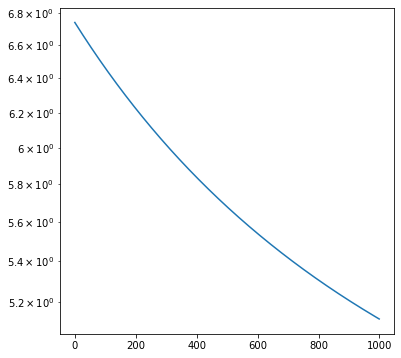

In [38]:
plt.semilogy(loss_gd)

In [39]:
#N_iter = 10

#x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [40]:
#plt.plot(loss_n)

In [56]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk, x_cg_all = cg(AA, Ab, x0, N_iter, verbose=True)
loss_cg = jax.vmap(F)(jnp.array(x_cg_all))

  cg iter 0 ||r|| = 1.108306237642001
  cg iter 100 ||r|| = 8.29667203828077e-13
  cg iter 200 ||r|| = 5.956045234118936e-15
  cg iter 300 ||r|| = 6.596325677426855e-15
  cg iter 400 ||r|| = 5.47930751352977e-15
  cg iter 500 ||r|| = 4.186591489103448e-15
  cg iter 600 ||r|| = 3.1385961520764295e-15
  cg iter 700 ||r|| = 3.5430524779743876e-15
  cg iter 800 ||r|| = 2.3800339019096163e-15
  cg iter 900 ||r|| = 3.2346027589887928e-15


In [57]:
print(F(x_gt))
print(F(x_cg))
print(F(x_gd))
#print(F(x_n))

1.2041735852363287
3.6776915647669313
5.119247603853377


#### OASIS

In [58]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [59]:
# Estimating D0

iters = 100000
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

#D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


100%|██████████| 100000/100000 [00:36<00:00, 2746.40it/s]


In [60]:
#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [65]:
N_iter = 1000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 100)


Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00, 259.39it/s, loss=3.763e+00]

  Loss =  3.763e+00


Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00, 184.49it/s, loss=3.729e+00]

  Loss =  3.729e+00


Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00, 132.61it/s, loss=3.710e+00]

  Loss =  3.710e+00


Epoch 400/1000


100%|██████████| 1/1 [00:00<00:00, 177.51it/s, loss=3.699e+00]

  Loss =  3.699e+00


Epoch 500/1000


100%|██████████| 1/1 [00:00<00:00, 175.06it/s, loss=3.692e+00]

  Loss =  3.692e+00


Epoch 600/1000


100%|██████████| 1/1 [00:00<00:00, 150.60it/s, loss=3.687e+00]

  Loss =  3.687e+00


Epoch 700/1000


100%|██████████| 1/1 [00:00<00:00, 134.71it/s, loss=3.684e+00]

  Loss =  3.684e+00


Epoch 800/1000


100%|██████████| 1/1 [00:00<00:00, 195.73it/s, loss=3.682e+00]

  Loss =  3.682e+00


Epoch 900/1000


100%|██████████| 1/1 [00:00<00:00, 247.80it/s, loss=3.681e+00]

  Loss =  3.681e+00


Epoch 1000/1000


100%|██████████| 1/1 [00:00<00:00, 180.10it/s, loss=3.680e+00]

  Loss =  3.680e+00


In [62]:
N_iter = 1000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


Epoch 500/1000


100%|██████████| 1/1 [00:00<00:00, 190.54it/s, loss=3.680e+00]

  Loss =  3.680e+00


Epoch 1000/1000


100%|██████████| 1/1 [00:00<00:00, 133.74it/s, loss=3.678e+00]

  Loss =  3.678e+00


1.0313333104989832
1.3058539672616098
1.0341270889706118
1.0304679494768392


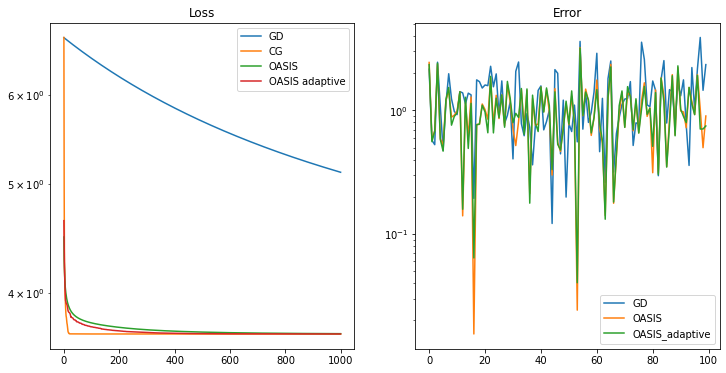

In [63]:
#print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt-x_cg)))
print(jnp.mean(jnp.abs(x_gt-x_gd)))
print(jnp.mean(jnp.abs(x_gt-x_o)))
print(jnp.mean(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 1000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_cg[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "CG", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
#plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [66]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to run SGD/OASIS on:

In [67]:
sig_noise = 10
lam = 0.1

In [74]:
n = 100
N = 1000

key, subkey = random.split(key)

x_gt = random.normal(subkey, (n,), dtype=jnp.complex128)

ops = []
b = []
for i in range(N):
    key, *subkeys = random.split(key, 4)
    
    A = random.normal(subkeys[0], (n,n), dtype = x_gt.dtype)
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.logspace(10,-5,n) + random.normal(subkeys[1], (n,), dtype = jnp.double)*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + random.normal(subkeys[2], (n,), dtype = x_gt.dtype) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [79]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

 4.26e+08


In [80]:
print(jnp.max(w))
print(jnp.min(w))

10000000035.65433
23.482235079674624


In [81]:
def loss_term(x, A, b):
    return 1/2 * jnp.real(jnp.mean(jnp.conj(A@x - b)*(A@x - b)) + lam * jnp.mean(jnp.conj(x)*x))

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [82]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

53.77126044871274
49.76565318421393
(100,)
(100,)
(100,)
(100,)


In [83]:
key, subkey = random.split(key)

hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = random.normal(subkey, (n,), dtype = x_gt.dtype)

In [85]:
Fidx(x_gt, jnp.arange(N))

DeviceArray(49.76565318, dtype=float64)

In [86]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good
#D0exact = jnp.diag(hessianF(x0)) # This is cheating

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)


#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

100%|██████████| 10000/10000 [00:35<00:00, 279.94it/s]


In [92]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|██████████| 50/50 [00:00<00:00, 116.97it/s, loss=5.828e+14]


  Loss =  7.438e+14
Epoch 2/20


100%|██████████| 50/50 [00:00<00:00, 109.64it/s, loss=1.071e+12]


  Loss =  1.269e+12
Epoch 3/20


100%|██████████| 50/50 [00:00<00:00, 115.80it/s, loss=4.454e+09]


  Loss =  4.462e+09
Epoch 4/20


100%|██████████| 50/50 [00:00<00:00, 115.75it/s, loss=1.588e+07]


  Loss =  1.942e+07
Epoch 5/20


100%|██████████| 50/50 [00:00<00:00, 117.87it/s, loss=7.182e+04]


  Loss =  8.418e+04
Epoch 6/20


100%|██████████| 50/50 [00:00<00:00, 115.24it/s, loss=3.326e+02]


  Loss =  4.565e+02
Epoch 7/20


100%|██████████| 50/50 [00:00<00:00, 113.95it/s, loss=5.154e+01]


  Loss =  5.145e+01
Epoch 8/20


100%|██████████| 50/50 [00:00<00:00, 112.96it/s, loss=4.939e+01]


  Loss =  4.981e+01
Epoch 9/20


100%|██████████| 50/50 [00:00<00:00, 112.80it/s, loss=4.879e+01]


  Loss =  4.987e+01
Epoch 10/20


100%|██████████| 50/50 [00:00<00:00, 124.35it/s, loss=4.909e+01]


  Loss =  4.980e+01
Epoch 11/20


100%|██████████| 50/50 [00:00<00:00, 113.36it/s, loss=4.753e+01]


  Loss =  4.985e+01
Epoch 12/20


100%|██████████| 50/50 [00:00<00:00, 122.65it/s, loss=4.952e+01]


  Loss =  4.984e+01
Epoch 13/20


100%|██████████| 50/50 [00:00<00:00, 115.52it/s, loss=5.083e+01]


  Loss =  4.982e+01
Epoch 14/20


100%|██████████| 50/50 [00:00<00:00, 111.57it/s, loss=4.969e+01]


  Loss =  4.997e+01
Epoch 15/20


100%|██████████| 50/50 [00:00<00:00, 109.18it/s, loss=4.876e+01]


  Loss =  4.987e+01
Epoch 16/20


100%|██████████| 50/50 [00:00<00:00, 120.12it/s, loss=4.943e+01]


  Loss =  4.987e+01
Epoch 17/20


100%|██████████| 50/50 [00:00<00:00, 112.93it/s, loss=4.986e+01]


  Loss =  5.013e+01
Epoch 18/20


100%|██████████| 50/50 [00:00<00:00, 115.97it/s, loss=5.025e+01]


  Loss =  4.982e+01
Epoch 19/20


100%|██████████| 50/50 [00:00<00:00, 111.56it/s, loss=5.123e+01]


  Loss =  5.014e+01
Epoch 20/20


100%|██████████| 50/50 [00:00<00:00, 110.65it/s, loss=4.951e+01]


  Loss =  4.986e+01


In [93]:
N_epoch = 20
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|██████████| 50/50 [00:01<00:00, 32.10it/s, loss=4.690e+15]


  Loss =  5.990e+15
Epoch 2/20


100%|██████████| 50/50 [00:00<00:00, 77.02it/s, loss=6.370e+13]


  Loss =  6.799e+13
Epoch 3/20


100%|██████████| 50/50 [00:00<00:00, 71.58it/s, loss=7.182e+11]


  Loss =  7.523e+11
Epoch 4/20


100%|██████████| 50/50 [00:00<00:00, 69.81it/s, loss=1.274e+10]


  Loss =  1.280e+10
Epoch 5/20


100%|██████████| 50/50 [00:00<00:00, 78.14it/s, loss=2.074e+08]


  Loss =  2.186e+08
Epoch 6/20


100%|██████████| 50/50 [00:00<00:00, 75.45it/s, loss=2.006e+06]


  Loss =  2.572e+06
Epoch 7/20


100%|██████████| 50/50 [00:00<00:00, 76.60it/s, loss=2.257e+04]


  Loss =  2.513e+04
Epoch 8/20


100%|██████████| 50/50 [00:00<00:00, 75.93it/s, loss=6.256e+02]


  Loss =  6.188e+02
Epoch 9/20


100%|██████████| 50/50 [00:00<00:00, 72.88it/s, loss=5.921e+01]


  Loss =  5.842e+01
Epoch 10/20


100%|██████████| 50/50 [00:00<00:00, 75.10it/s, loss=5.002e+01]


  Loss =  4.999e+01
Epoch 11/20


100%|██████████| 50/50 [00:00<00:00, 74.39it/s, loss=5.028e+01]


  Loss =  4.981e+01
Epoch 12/20


100%|██████████| 50/50 [00:00<00:00, 75.85it/s, loss=4.802e+01]


  Loss =  4.977e+01
Epoch 13/20


100%|██████████| 50/50 [00:00<00:00, 77.74it/s, loss=5.233e+01]


  Loss =  4.979e+01
Epoch 14/20


100%|██████████| 50/50 [00:00<00:00, 75.63it/s, loss=5.030e+01]


  Loss =  4.983e+01
Epoch 15/20


100%|██████████| 50/50 [00:00<00:00, 74.90it/s, loss=4.940e+01]


  Loss =  4.978e+01
Epoch 16/20


100%|██████████| 50/50 [00:00<00:00, 78.20it/s, loss=4.865e+01]


  Loss =  4.978e+01
Epoch 17/20


100%|██████████| 50/50 [00:00<00:00, 76.64it/s, loss=5.044e+01]


  Loss =  4.977e+01
Epoch 18/20


100%|██████████| 50/50 [00:00<00:00, 78.89it/s, loss=4.750e+01]


  Loss =  4.979e+01
Epoch 19/20


100%|██████████| 50/50 [00:00<00:00, 74.98it/s, loss=4.912e+01]


  Loss =  4.976e+01
Epoch 20/20


100%|██████████| 50/50 [00:00<00:00, 78.96it/s, loss=4.913e+01]


  Loss =  4.980e+01


In [97]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

Epoch 1/20


100%|██████████| 1/1 [00:00<00:00, 62.90it/s, loss=1.071e+18]


  Loss =  1.071e+18
Epoch 2/20


100%|██████████| 1/1 [00:00<00:00, 64.16it/s, loss=8.898e+17]


  Loss =  8.898e+17
Epoch 3/20


100%|██████████| 1/1 [00:00<00:00, 78.58it/s, loss=7.435e+17]


  Loss =  7.435e+17
Epoch 4/20


100%|██████████| 1/1 [00:00<00:00, 80.36it/s, loss=6.230e+17]


  Loss =  6.230e+17
Epoch 5/20


100%|██████████| 1/1 [00:00<00:00, 75.18it/s, loss=5.230e+17]


  Loss =  5.230e+17
Epoch 6/20


100%|██████████| 1/1 [00:00<00:00, 65.87it/s, loss=4.398e+17]


  Loss =  4.398e+17
Epoch 7/20


100%|██████████| 1/1 [00:00<00:00, 69.54it/s, loss=3.705e+17]


  Loss =  3.705e+17
Epoch 8/20


100%|██████████| 1/1 [00:00<00:00, 73.46it/s, loss=3.126e+17]


  Loss =  3.126e+17
Epoch 9/20


100%|██████████| 1/1 [00:00<00:00, 66.28it/s, loss=2.642e+17]


  Loss =  2.642e+17
Epoch 10/20


100%|██████████| 1/1 [00:00<00:00, 75.40it/s, loss=2.238e+17]


  Loss =  2.238e+17
Epoch 11/20


100%|██████████| 1/1 [00:00<00:00, 60.64it/s, loss=1.898e+17]


  Loss =  1.898e+17
Epoch 12/20


100%|██████████| 1/1 [00:00<00:00, 44.33it/s, loss=1.613e+17]


  Loss =  1.613e+17
Epoch 13/20


100%|██████████| 1/1 [00:00<00:00, 67.10it/s, loss=1.373e+17]


  Loss =  1.373e+17
Epoch 14/20


100%|██████████| 1/1 [00:00<00:00, 70.75it/s, loss=1.170e+17]


  Loss =  1.170e+17
Epoch 15/20


100%|██████████| 1/1 [00:00<00:00, 82.21it/s, loss=9.987e+16]


  Loss =  9.987e+16
Epoch 16/20


100%|██████████| 1/1 [00:00<00:00, 82.97it/s, loss=8.538e+16]


  Loss =  8.538e+16
Epoch 17/20


100%|██████████| 1/1 [00:00<00:00, 74.01it/s, loss=7.306e+16]


  Loss =  7.306e+16
Epoch 18/20


100%|██████████| 1/1 [00:00<00:00, 78.58it/s, loss=6.258e+16]


  Loss =  6.258e+16
Epoch 19/20


100%|██████████| 1/1 [00:00<00:00, 88.45it/s, loss=5.371e+16]


  Loss =  5.371e+16
Epoch 20/20


100%|██████████| 1/1 [00:00<00:00, 69.64it/s, loss=4.621e+16]


  Loss =  4.621e+16


In [100]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


Epoch 1/20


100%|██████████| 1/1 [00:00<00:00, 41.11it/s, loss=1.178e+18]


  Loss =  1.178e+18
Epoch 2/20


100%|██████████| 1/1 [00:00<00:00, 35.66it/s, loss=1.055e+18]


  Loss =  1.055e+18
Epoch 3/20


100%|██████████| 1/1 [00:00<00:00, 40.05it/s, loss=8.979e+17]


  Loss =  8.979e+17
Epoch 4/20


100%|██████████| 1/1 [00:00<00:00, 32.33it/s, loss=6.954e+17]


  Loss =  6.954e+17
Epoch 5/20


100%|██████████| 1/1 [00:00<00:00, 34.51it/s, loss=4.578e+17]


  Loss =  4.578e+17
Epoch 6/20


100%|██████████| 1/1 [00:00<00:00, 36.69it/s, loss=2.295e+17]


  Loss =  2.295e+17
Epoch 7/20


100%|██████████| 1/1 [00:00<00:00, 33.27it/s, loss=9.009e+16]


  Loss =  9.009e+16
Epoch 8/20


100%|██████████| 1/1 [00:00<00:00, 39.85it/s, loss=1.167e+17]


  Loss =  1.167e+17
Epoch 9/20


100%|██████████| 1/1 [00:00<00:00, 41.68it/s, loss=6.199e+16]


  Loss =  6.199e+16
Epoch 10/20


100%|██████████| 1/1 [00:00<00:00, 46.27it/s, loss=5.168e+16]


  Loss =  5.168e+16
Epoch 11/20


100%|██████████| 1/1 [00:00<00:00, 47.87it/s, loss=4.710e+16]


  Loss =  4.710e+16
Epoch 12/20


100%|██████████| 1/1 [00:00<00:00, 45.87it/s, loss=4.357e+16]


  Loss =  4.357e+16
Epoch 13/20


100%|██████████| 1/1 [00:00<00:00, 42.69it/s, loss=3.928e+16]


  Loss =  3.928e+16
Epoch 14/20


100%|██████████| 1/1 [00:00<00:00, 43.88it/s, loss=3.333e+16]


  Loss =  3.333e+16
Epoch 15/20


100%|██████████| 1/1 [00:00<00:00, 44.82it/s, loss=2.548e+16]


  Loss =  2.548e+16
Epoch 16/20


100%|██████████| 1/1 [00:00<00:00, 48.07it/s, loss=1.637e+16]

  Loss =  1.637e+16


Epoch 17/20


100%|██████████| 1/1 [00:00<00:00, 45.13it/s, loss=7.762e+15]


  Loss =  7.762e+15
Epoch 18/20


100%|██████████| 1/1 [00:00<00:00, 43.35it/s, loss=5.468e+15]


  Loss =  5.468e+15
Epoch 19/20


100%|██████████| 1/1 [00:00<00:00, 43.92it/s, loss=3.378e+15]


  Loss =  3.378e+15
Epoch 20/20


100%|██████████| 1/1 [00:00<00:00, 40.70it/s, loss=2.916e+15]

  Loss =  2.916e+15


In [107]:
N_epoch = 20
eta = 1e-18
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

Epoch 1/20 

100%|██████████| 50/50 [00:00<00:00, 292.60it/s, grad=4.515e+16, loss=3.212e+17]


  |Grad| = 6.074e+16
  Loss = 2.783e+17
Epoch 2/20 

100%|██████████| 50/50 [00:00<00:00, 331.56it/s, grad=1.256e+16, loss=4.744e+16]


  |Grad| = 2.472e+16
  Loss = 5.848e+16
Epoch 3/20 

100%|██████████| 50/50 [00:00<00:00, 292.11it/s, grad=8.275e+15, loss=1.303e+16]


  |Grad| = 1.176e+16
  Loss = 1.371e+16
Epoch 4/20 

100%|██████████| 50/50 [00:00<00:00, 287.23it/s, grad=5.202e+15, loss=3.688e+15]


  |Grad| = 5.681e+15
  Loss = 3.537e+15
Epoch 5/20 

100%|██████████| 50/50 [00:00<00:00, 290.48it/s, grad=1.589e+15, loss=9.607e+14]


  |Grad| = 2.913e+15
  Loss = 9.635e+14
Epoch 6/20 

100%|██████████| 50/50 [00:00<00:00, 286.21it/s, grad=1.134e+15, loss=2.760e+14]


  |Grad| = 1.505e+15
  Loss = 2.752e+14
Epoch 7/20 

100%|██████████| 50/50 [00:00<00:00, 284.25it/s, grad=1.085e+15, loss=9.383e+13]


  |Grad| = 8.290e+14
  Loss = 8.185e+13
Epoch 8/20 

100%|██████████| 50/50 [00:00<00:00, 303.05it/s, grad=3.091e+14, loss=2.250e+13]


  |Grad| = 4.439e+14
  Loss = 2.468e+13
Epoch 9/20 

100%|██████████| 50/50 [00:00<00:00, 319.62it/s, grad=2.068e+14, loss=7.909e+12]


  |Grad| = 2.526e+14
  Loss = 7.818e+12
Epoch 10/20 

100%|██████████| 50/50 [00:00<00:00, 306.53it/s, grad=1.700e+14, loss=2.479e+12]


  |Grad| = 1.393e+14
  Loss = 2.419e+12
Epoch 11/20 

100%|██████████| 50/50 [00:00<00:00, 314.35it/s, grad=5.078e+13, loss=7.380e+11]


  |Grad| = 7.356e+13
  Loss = 7.740e+11
Epoch 12/20 

100%|██████████| 50/50 [00:00<00:00, 333.84it/s, grad=3.435e+13, loss=2.382e+11]


  |Grad| = 4.491e+13
  Loss = 2.511e+11
Epoch 13/20 

100%|██████████| 50/50 [00:00<00:00, 321.93it/s, grad=2.373e+13, loss=8.577e+10]


  |Grad| = 2.554e+13
  Loss = 8.205e+10
Epoch 14/20 

100%|██████████| 50/50 [00:00<00:00, 303.66it/s, grad=1.039e+13, loss=3.162e+10]


  |Grad| = 1.423e+13
  Loss = 2.708e+10
Epoch 15/20 

100%|██████████| 50/50 [00:00<00:00, 318.03it/s, grad=7.329e+12, loss=8.889e+09]


  |Grad| = 8.428e+12
  Loss = 9.014e+09
Epoch 16/20 

100%|██████████| 50/50 [00:00<00:00, 303.32it/s, grad=2.932e+12, loss=2.888e+09]


  |Grad| = 4.530e+12
  Loss = 3.033e+09
Epoch 17/20 

100%|██████████| 50/50 [00:00<00:00, 312.97it/s, grad=1.724e+12, loss=9.353e+08]


  |Grad| = 2.749e+12
  Loss = 1.012e+09
Epoch 18/20 

100%|██████████| 50/50 [00:00<00:00, 296.79it/s, grad=1.247e+12, loss=3.861e+08]


  |Grad| = 1.554e+12
  Loss = 3.407e+08
Epoch 19/20 

100%|██████████| 50/50 [00:00<00:00, 312.65it/s, grad=6.115e+11, loss=1.192e+08]


  |Grad| = 9.472e+11
  Loss = 1.159e+08
Epoch 20/20 

100%|██████████| 50/50 [00:00<00:00, 321.58it/s, grad=4.323e+11, loss=3.814e+07]


  |Grad| = 5.354e+11
  Loss = 3.944e+07


In [110]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1
                       
key, subkey = random.split(key)
x_sgdp, loss_sgdp, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, P = 1/D0, verbose = True, iter_display = 1)

Epoch 1/20 

100%|██████████| 50/50 [00:00<00:00, 312.38it/s, grad=2.429e+15, loss=6.788e+14]


  |Grad| = 2.511e+16
  Loss = 6.538e+14
Epoch 2/20 

100%|██████████| 50/50 [00:00<00:00, 309.05it/s, grad=1.068e+14, loss=1.315e+12]


  |Grad| = 6.422e+14
  Loss = 1.284e+12
Epoch 3/20 

100%|██████████| 50/50 [00:00<00:00, 334.71it/s, grad=5.464e+12, loss=3.085e+09]


  |Grad| = 2.660e+13
  Loss = 4.006e+09
Epoch 4/20 

100%|██████████| 50/50 [00:00<00:00, 297.41it/s, grad=3.856e+11, loss=1.183e+07]


  |Grad| = 1.582e+12
  Loss = 1.341e+07
Epoch 5/20 

100%|██████████| 50/50 [00:00<00:00, 304.37it/s, grad=1.662e+10, loss=3.315e+04]


  |Grad| = 8.748e+10
  Loss = 3.612e+04
Epoch 6/20 

100%|██████████| 50/50 [00:00<00:00, 299.06it/s, grad=6.916e+08, loss=1.612e+02]


  |Grad| = 5.378e+09
  Loss = 1.988e+02
Epoch 7/20 

100%|██████████| 50/50 [00:00<00:00, 308.29it/s, grad=1.315e+08, loss=5.012e+01]


  |Grad| = 3.419e+08
  Loss = 5.033e+01
Epoch 8/20 

100%|██████████| 50/50 [00:00<00:00, 323.65it/s, grad=7.235e+07, loss=4.889e+01]


  |Grad| = 9.403e+07
  Loss = 4.982e+01
Epoch 9/20 

100%|██████████| 50/50 [00:00<00:00, 316.03it/s, grad=7.965e+07, loss=5.090e+01]


  |Grad| = 8.931e+07
  Loss = 4.989e+01
Epoch 10/20 

100%|██████████| 50/50 [00:00<00:00, 299.51it/s, grad=1.214e+08, loss=5.120e+01]

  |Grad| = 8.714e+07
  Loss = 5.004e+01
Epoch 11/20 


100%|██████████| 50/50 [00:00<00:00, 326.16it/s, grad=6.120e+07, loss=5.033e+01]


  |Grad| = 8.227e+07
  Loss = 4.981e+01
Epoch 12/20 

100%|██████████| 50/50 [00:00<00:00, 329.41it/s, grad=8.100e+07, loss=5.025e+01]


  |Grad| = 8.421e+07
  Loss = 4.982e+01
Epoch 13/20 

100%|██████████| 50/50 [00:00<00:00, 319.22it/s, grad=7.265e+07, loss=4.870e+01]


  |Grad| = 8.240e+07
  Loss = 4.984e+01
Epoch 14/20 

100%|██████████| 50/50 [00:00<00:00, 306.44it/s, grad=8.722e+07, loss=4.987e+01]


  |Grad| = 8.988e+07
  Loss = 4.982e+01
Epoch 15/20 

100%|██████████| 50/50 [00:00<00:00, 328.04it/s, grad=9.302e+07, loss=4.870e+01]


  |Grad| = 8.306e+07
  Loss = 4.987e+01
Epoch 16/20 

100%|██████████| 50/50 [00:00<00:00, 319.06it/s, grad=5.766e+07, loss=5.227e+01]


  |Grad| = 8.803e+07
  Loss = 4.980e+01
Epoch 17/20 

100%|██████████| 50/50 [00:00<00:00, 301.55it/s, grad=5.724e+07, loss=4.898e+01]


  |Grad| = 8.555e+07
  Loss = 4.981e+01
Epoch 18/20 

100%|██████████| 50/50 [00:00<00:00, 328.26it/s, grad=7.002e+07, loss=4.826e+01]


  |Grad| = 8.566e+07
  Loss = 4.988e+01
Epoch 19/20 

100%|██████████| 50/50 [00:00<00:00, 299.48it/s, grad=7.466e+07, loss=4.977e+01]


  |Grad| = 8.283e+07
  Loss = 4.982e+01
Epoch 20/20 

100%|██████████| 50/50 [00:00<00:00, 352.10it/s, grad=1.091e+08, loss=4.976e+01]


  |Grad| = 8.015e+07
  Loss = 4.982e+01


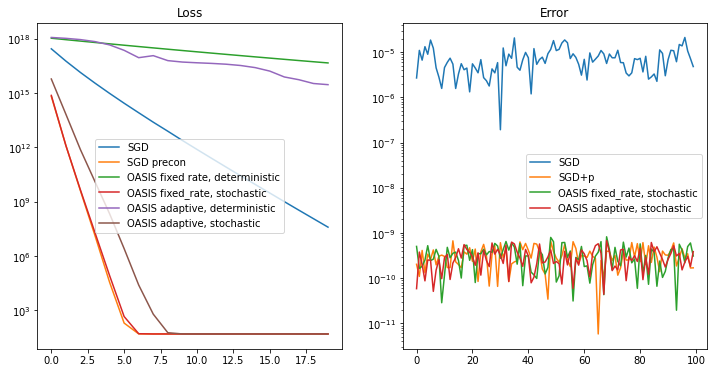

In [111]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
plt.semilogy(loss_sgdp)
plt.semilogy(loss_o)
plt.semilogy(loss_os)
plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
plt.legend(["SGD", "SGD precon", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
#plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
plt.semilogy(jnp.abs(x_sgdp-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "SGD+p", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

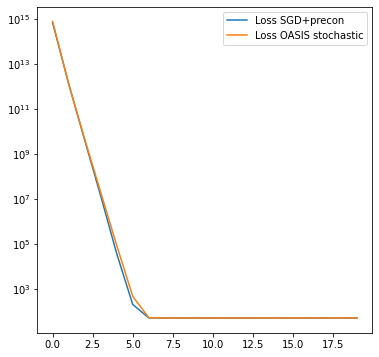

In [112]:
plt.semilogy(loss_sgdp)
plt.semilogy(loss_os)
plt.legend(["Loss SGD+precon", "Loss OASIS stochastic"])

In [113]:
print(Fidx(x_gt, jnp.arange(N)))
print(Fidx(x_sgd, jnp.arange(N)))
print(Fidx(x_sgdp, jnp.arange(N)))
print(Fidx(x_o, jnp.arange(N)))
print(Fidx(x_os, jnp.arange(N)))
print(Fidx(x_oa, jnp.arange(N)))
print(Fidx(x_osa, jnp.arange(N)))


49.76565318421393
39443928.180767894
49.819126909571935
4.621496633453002e+16
49.86056493743132
2915684467424945.0
49.80180892207274


Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* In the stochastic toy problem case, also compare with CG (make the problem small enough so that we can do CG)
* ~~Implement some kind of warm up /estimation of $D_0$~~
* ~~Run on CryoEM data~~